# Sentiment Analysis with Gate Recurrent Unit Network

GRU stands for Gated Recurrent Unit. It's a type of neural network architecture that is particularly well-suited for processing sequential data. Some of the main properties of GRUs include:

1. Gating mechanism: GRUs use a gating mechanism to control the flow of information between time steps, which helps to prevent the vanishing or exploding gradient problem.
2. Recurrent connections: GRUs have recurrent connections that allow the network to capture long-term dependencies in the data.
3. Simple and efficient: GRUs are relatively simple to implement and train compared to other RNN architectures, making them a popular choice for many applications.

##  Objective : 
- Predict the rating positive or negative from the customer's comment with a Recurrent Neural Network model

##  Required packages

In [26]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from time import time

from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# import customized function to plot charts for performance comparison
from plot_metrics import plot_radar_mult, plot_radar_metrics, barplot_metric_mult, \
                        lineplot_metrics, stack_barplot, \
                        barplot_model_vs_metrics_group, barplot_models_group_vs_metric



## Load data

In [2]:
df = pd.read_csv("data_for_rnn.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23336 entries, 0 to 23335
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       23336 non-null  int64 
 1   comment          23336 non-null  object
 2   comment_cleaned  23336 non-null  object
 3   comment_stem     23336 non-null  object
 4   rating           23336 non-null  int64 
 5   sentiment_r      23336 non-null  int64 
 6   sentiment_rmc    23336 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 1.2+ MB


In [3]:
X = df["comment_cleaned"]
y = df["sentiment_r"]
ym = df["sentiment_rmc"]  # target for multiclass calssification pos rating, neutral rating, neg rating

In [4]:
# Number of distinct words in all comment_cleaned 
txt = " ".join(X).split()
print("total number of distinct words in all comment_cleaned:", len(set(txt)))


total number of distinct words in all comment_cleaned: 4122


## Tokenization and numerisation

In [5]:
num_words = 10000

tokenizer = Tokenizer(num_words=num_words)
# The default values of "filters" are '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'. 

# Updates internal vocabulary based on a list of texts.
tokenizer.fit_on_texts(X)

###  Create word Index

In [6]:
tokenizer.word_index

{'livraison': 1,
 'rapide': 2,
 'très': 3,
 'rapidité': 4,
 'commande': 5,
 'qualité': 6,
 'bien': 7,
 'produit': 8,
 'produits': 9,
 'articles': 10,
 'colis': 11,
 'conforme': 12,
 'prix': 13,
 'plus': 14,
 'redoute': 15,
 'choix': 16,
 'article': 17,
 'parfait': 18,
 'site': 19,
 'bonne': 20,
 'envoi': 21,
 'bon': 22,
 'relais': 23,
 'merci': 24,
 'satisfaite': 25,
 'toujours': 26,
 'facile': 27,
 'reçu': 28,
 'retour': 29,
 'rien': 30,
 'délai': 31,
 'achat': 32,
 'service': 33,
 'description': 34,
 'délais': 35,
 'commandé': 36,
 'taille': 37,
 'rapidement': 38,
 'facilité': 39,
 'point': 40,
 'conformes': 41,
 'sans': 42,
 'temps': 43,
 'expédition': 44,
 'beaucoup': 45,
 'top': 46,
 'livré': 47,
 'trop': 48,
 'suivi': 49,
 'rapport': 50,
 'attentes': 51,
 'super': 52,
 'efficace': 53,
 'problème': 54,
 'couleur': 55,
 'peu': 56,
 'fois': 57,
 'correspond': 58,
 'depuis': 59,
 'après': 60,
 'déçue': 61,
 'dommage': 62,
 'réception': 63,
 'commander': 64,
 'photo': 65,
 'simple': 6

In [7]:
len(tokenizer.word_index) 

4122

###  Convert Tokens to numeric

In [8]:
X_num_tokens = tokenizer.texts_to_sequences(X)

In [9]:
num_tokens = [len(tokens) for tokens in X_num_tokens]
num_tokens = np.array(num_tokens)

In [10]:
X[100]

'failli pouvoir récupérer colis garder mail disait colis arrivé relais faudrait préciser client tant colis conserver mail sous peine colis'

In [11]:
print(X_num_tokens[100])

[2331, 220, 295, 11, 842, 177, 2126, 11, 76, 23, 731, 1056, 70, 509, 11, 3406, 177, 299, 1085, 11]


In [12]:
# each word is reprsented by a numeric token
print(tokenizer.word_index["relai"])
print(tokenizer.word_index["livreur"])

465
123


### Determine the maximum numbers of tokens

In [13]:
print("mean:", num_tokens.mean())
print("max:", num_tokens.max())

arg_max = num_tokens.argmax()
print("argmax:", arg_max)
print("X at argmax:", X[arg_max])
print("len(X[argmax]):", len(X[arg_max]))
print("----")
arg_min = num_tokens.argmin()
print("argmin:", arg_min)
print("X at argmin:", X[arg_min])
print("len(X[argmin]):", len(X[arg_min]))

mean: 7.7813678436750084
max: 148
argmax: 10888
X at argmax: époque où parents redoute où qualité aujourd hui ça vaut mieux marques tant niveau matériel services matelas commandé livré conditions plus déplorables photo appui emballage déchiré plusieurs endroits matelas part autre livreurs demander souhaitais garder évidemment accepté marchandise lit sans matelas poser dessus services après vente redoute proposé remboursement sous semaines après quoi pouvais nouveau passer commande attendre environ semaines recevoir nouveau matelas madame bien refusé marchandise fallu demande échange non aberrant agit miroir tapis salle bain matelas lequel devions dormir dû enfin obtenir remboursement immédiat repasser commande matelas arrivé peu plus semaines après demandé vigilance portée livraison façon revivre scénario arrivée livreurs matelas jeté arrière camion sans soin particulier emballage nouveau déchiré fort heureusement matelas sans parler livreurs marchandise cigarette main faut rappeler av

### Define Pad Sequences

In [14]:
max_tokens = num_tokens.max()
print("max_token:", max_tokens)

max_token: 148


In [15]:
sum(num_tokens < max_tokens) / len(num_tokens)

0.9999571477545424

In [16]:
sum(num_tokens < max_tokens) # the number of documents which have 148 or less tokens

23335

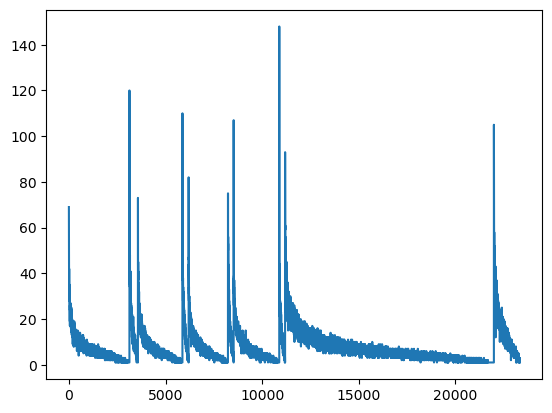

In [17]:
#Visualize trend of im_tokens
lon = len(num_tokens)
sns.lineplot(num_tokens)
plt.show()

## Padding

In [18]:
X_pad = pad_sequences(X_num_tokens, maxlen=max_tokens)
X_pad.shape

(23336, 148)

In [19]:
X_pad[100]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0, 2331,  220,  295,   11,
        842,  177, 2126,   11,   76,   23,  731, 1056,   70,  509,   11,
       3406,  177,  299, 1085,   11], dtype=int32)

## Train, test, split

In [20]:
from sklearn.model_selection import train_test_split

# split data int train data and test data (20% of data)
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=23)


In [21]:
X_train.shape

(18668, 148)

In [22]:
X_test.shape

(4668, 148)

## Modeling - Gated Recurrent Unit

In [23]:
# define early_stop callbacks
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", 
                           mode="auto", 
                           verbose=1, 
                           patience = 10, 
                           restore_best_weights=True)

In [32]:
#model GRU_0
model_name = "GRU_0"

embedding_size = 100
model = Sequential()

model.add(Embedding(input_dim=num_words, 
                    output_dim=embedding_size, 
                    input_length=max_tokens,
                    name="embedding_layer"))

model.add(GRU(units=48, return_sequences=True))
model.add(GRU(units=24, return_sequences=True)) 
model.add(GRU(units=12))
model.add(Dense(1, activation='sigmoid'))

# Compile
optimizer = Adam(learning_rate=0.006)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['recall'])

model.summary()


# fit and evaluate
weights = {0:88, 1:18}

t0 = time()
model.fit(X_train, y_train, 
          epochs=30, 
          batch_size=256, 
          class_weight=weights,
          validation_data=(X_test, y_test), 
          callbacks=[early_stop])
time_train = time() - t0

results = model.evaluate(X_test, y_test)
print("results:", results)

# prediction
t1 = time()
pred = model.predict(X_test)
time_predict = time() - t1  # records duration of predicting
prediction = (1 * (pred >= 0.5))[:, 0]

accuracy = metrics.accuracy_score(y_test, prediction)
# The balanced accuracy in binary and multiclass classification problems
# to deal with imbalanced datasets.
# It is defined as the average of recall obtained on each class.
# The best value is 1 and the worst value is 0 when adjusted=False.
balanced_accuracy = metrics.balanced_accuracy_score(y_test, prediction)

f1_score = metrics.f1_score(y_test, prediction)
f1_score_macro = metrics.f1_score(y_test, prediction, average="macro")
f1_score_weighted = metrics.f1_score(y_test, prediction, average="weighted")

recall = metrics.recall_score(y_test, prediction, pos_label=0)
recall_macro = metrics.recall_score(y_test, prediction, average="macro")
recall_weighted = metrics.recall_score(y_test, prediction, average="weighted")

# precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
# we set pos_label=0 : that is negative rating (rating <=3)
precision = metrics.precision_score(y_test, prediction, pos_label=0)
precision_macro = metrics.precision_score(y_test, prediction, average="macro")
precision_weighted = metrics.precision_score(y_test, prediction, average="weighted")

cl_report = metrics.classification_report(y_test, prediction)
cf_matrix = pd.crosstab(y_test, prediction, rownames=["Real"], colnames=["Prediction"])

# put metrics into a dictionnary and into a DataFrame
res = {
        "model": model_name,
        "accuracy": accuracy,
        "balanced_accuracy": balanced_accuracy,
        "f1": f1_score,
        "f1_macro": f1_score_macro,
        "f1_weighted": f1_score_weighted,
        "recall_0": recall,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "precision_0": precision,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "time_train": time_train,
        "time_predict": time_predict,
    }

# DataFrame of model's performance
df_p = pd.DataFrame(res, index=[0])

# Save performance data in a csv file
file_name = "perf_"+model_name+".csv"
df_p.to_csv(file_name)

# perf data to plot
data = df_p.iloc[:,:-2]

# Radar chart of model's performance
plot_radar_metrics(data, model_name)

# Barplot of models performance
model_list=[model_name]
barplot_models_group_vs_metric(data, model_list)


print(" Confusion matrix -----------------------------------")
display(cf_matrix)
print(" Classification Report -------------------------------")
print(cl_report)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding  (None, 148, 100)          1000000   
 )                                                               
                                                                 
 gru_15 (GRU)                (None, 148, 48)           21600     
                                                                 
 gru_16 (GRU)                (None, 148, 24)           5328      
                                                                 
 gru_17 (GRU)                (None, 12)                1368      
                                                                 
 dense_5 (Dense)             (None, 1)                 13        
                                                                 
Total params: 1028309 (3.92 MB)
Trainable params: 1028309 (3.92 MB)
Non-trainable params: 0 (0.00 Byte)
________________

 Confusion matrix -----------------------------------


Prediction,0,1
Real,,
0,445,94
1,345,3784


 Classification Report -------------------------------
              precision    recall  f1-score   support

           0       0.56      0.83      0.67       539
           1       0.98      0.92      0.95      4129

    accuracy                           0.91      4668
   macro avg       0.77      0.87      0.81      4668
weighted avg       0.93      0.91      0.91      4668



In [33]:
#model
model_name = "GRU_1"
embedding_size = 100
model2 = Sequential()

model2.add(Embedding(input_dim=num_words, 
                    output_dim=embedding_size, 
                    input_length=max_tokens,
                    name="embedding_layer"))

model2.add(GRU(units=128, return_sequences=True))
model2.add(GRU(units=64, return_sequences=True)) 
model2.add(GRU(units=12))
model2.add(Dense(1, activation='sigmoid'))

# Compile
optimizer = Adam(learning_rate=0.008)

model2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model2.summary()

# fit and evaluate
weights = {0:88, 1:18}

t0 = time()
model2.fit(X_train, y_train, 
          epochs=30, 
          batch_size=256, 
          class_weight=weights,
          validation_data=(X_test, y_test), 
          callbacks=[early_stop])
time_train = time() - t0

results = model2.evaluate(X_test, y_test)
print("results:", results)

# prediction
t1 = time()
pred = model2.predict(X_test)
time_predict = time() - t1  # records duration of predicting
prediction = (1 * (pred >= 0.5))[:, 0]


accuracy = metrics.accuracy_score(y_test, prediction)
# The balanced accuracy in binary and multiclass classification problems
# to deal with imbalanced datasets.
# It is defined as the average of recall obtained on each class.
# The best value is 1 and the worst value is 0 when adjusted=False.
balanced_accuracy = metrics.balanced_accuracy_score(y_test, prediction)

f1_score = metrics.f1_score(y_test, prediction)
f1_score_macro = metrics.f1_score(y_test, prediction, average="macro")
f1_score_weighted = metrics.f1_score(y_test, prediction, average="weighted")

recall = metrics.recall_score(y_test, prediction, pos_label=0)
recall_macro = metrics.recall_score(y_test, prediction, average="macro")
recall_weighted = metrics.recall_score(y_test, prediction, average="weighted")

# precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
# we set pos_label=0 : that is negative rating (rating <=3)
precision = metrics.precision_score(y_test, prediction, pos_label=0)
precision_macro = metrics.precision_score(y_test, prediction, average="macro")
precision_weighted = metrics.precision_score(y_test, prediction, average="weighted")

cl_report = metrics.classification_report(y_test, prediction)
cf_matrix = pd.crosstab(y_test, prediction, rownames=["Real"], colnames=["Prediction"])

# put metrics into a dictionnary and into a DataFrame
res = {
        "model": model_name,
        "accuracy": accuracy,
        "balanced_accuracy": balanced_accuracy,
        "f1": f1_score,
        "f1_macro": f1_score_macro,
        "f1_weighted": f1_score_weighted,
        "recall_0": recall,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "precision_0": precision,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "time_train": time_train,
        "time_predict": time_predict,
    }

# DataFrame of model's performance
df_p2 = pd.DataFrame(res, index=[0])

# Save performance data in a csv file
file_name = "perf_"+model_name+".csv"
df_p2.to_csv(file_name)

# Radar chart of model's performance
data = df_p2.iloc[:,:-2]
plot_radar_metrics(data, model_name)

# Barplot of models performance
# Comparision with TfidfVectorizr & Logistic Regression 
model_list=[model_name]
barplot_models_group_vs_metric(data, model_list)


print("-- Confusion matrix -----------------------------------")
display(cf_matrix)
print("-- Classification Report -------------------------------")
print(cl_report)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding  (None, 148, 100)          1000000   
 )                                                               
                                                                 
 gru_18 (GRU)                (None, 148, 128)          88320     
                                                                 
 gru_19 (GRU)                (None, 148, 64)           37248     
                                                                 
 gru_20 (GRU)                (None, 12)                2808      
                                                                 
 dense_6 (Dense)             (None, 1)                 13        
                                                                 
Total params: 1128389 (4.30 MB)
Trainable params: 1128389 (4.30 MB)
Non-trainable params: 0 (0.00 Byte)
________________

-- Confusion matrix -----------------------------------


Prediction,0,1
Real,,
0,414,125
1,193,3936


-- Classification Report -------------------------------
              precision    recall  f1-score   support

           0       0.68      0.77      0.72       539
           1       0.97      0.95      0.96      4129

    accuracy                           0.93      4668
   macro avg       0.83      0.86      0.84      4668
weighted avg       0.94      0.93      0.93      4668



In [ ]:
#model change weights = {0:88, 1:18} to weights = {0:88, 1:12}
model_name = "GRU_1bis"
embedding_size = 100
model2 = Sequential()

model2.add(Embedding(input_dim=num_words, 
                    output_dim=embedding_size, 
                    input_length=max_tokens,
                    name="embedding_layer"))

model2.add(GRU(units=128, return_sequences=True))
model2.add(GRU(units=64, return_sequences=True)) 
model2.add(GRU(units=12))
model2.add(Dense(1, activation='sigmoid'))

# Compile
optimizer = Adam(learning_rate=0.008)

model2.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model2.summary()

# fit and evaluate
weights = {0:88, 1:12}

t0 = time()
model2.fit(X_train, y_train, 
          epochs=30, 
          batch_size=256, 
          class_weight=weights,
          validation_data=(X_test, y_test), 
          callbacks=[early_stop])
time_train = time() - t0

results = model2.evaluate(X_test, y_test)
print("results:", results)

# prediction
t1 = time()
pred = model2.predict(X_test)
time_predict = time() - t1  # records duration of predicting
prediction = (1 * (pred >= 0.5))[:, 0]


accuracy = metrics.accuracy_score(y_test, prediction)
# The balanced accuracy in binary and multiclass classification problems
# to deal with imbalanced datasets.
# It is defined as the average of recall obtained on each class.
# The best value is 1 and the worst value is 0 when adjusted=False.
balanced_accuracy = metrics.balanced_accuracy_score(y_test, prediction)

f1_score = metrics.f1_score(y_test, prediction)
f1_score_macro = metrics.f1_score(y_test, prediction, average="macro")
f1_score_weighted = metrics.f1_score(y_test, prediction, average="weighted")

recall = metrics.recall_score(y_test, prediction, pos_label=0)
recall_macro = metrics.recall_score(y_test, prediction, average="macro")
recall_weighted = metrics.recall_score(y_test, prediction, average="weighted")

# precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
# we set pos_label=0 : that is negative rating (rating <=3)
precision = metrics.precision_score(y_test, prediction, pos_label=0)
precision_macro = metrics.precision_score(y_test, prediction, average="macro")
precision_weighted = metrics.precision_score(y_test, prediction, average="weighted")

cl_report = metrics.classification_report(y_test, prediction)
cf_matrix = pd.crosstab(y_test, prediction, rownames=["Real"], colnames=["Prediction"])

# put metrics into a dictionnary and into a DataFrame
res = {
        "model": model_name,
        "accuracy": accuracy,
        "balanced_accuracy": balanced_accuracy,
        "f1": f1_score,
        "f1_macro": f1_score_macro,
        "f1_weighted": f1_score_weighted,
        "recall_0": recall,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "precision_0": precision,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "time_train": time_train,
        "time_predict": time_predict,
    }

# DataFrame of model's performance
df_p2 = pd.DataFrame(res, index=[0])

# Save performance data in a csv file
file_name = "perf_"+model_name+".csv"
df_p2.to_csv(file_name)

# Radar chart of model's performance
data = df_p2.iloc[:,:-2]
plot_radar_metrics(data, model_name)

# Barplot of models performance
# Comparision with TfidfVectorizr & Logistic Regression 
model_list=[model_name]
barplot_models_group_vs_metric(data, model_list)


print("-- Confusion matrix -----------------------------------")
display(cf_matrix)
print("-- Classification Report -------------------------------")
print(cl_report)

In [34]:
#model GRU_2
model_name = "GRU_2"

embedding_size = 100
model3 = Sequential()

model3.add(Embedding(input_dim=num_words, 
                    output_dim=embedding_size, 
                    input_length=max_tokens,
                    name="embedding_layer"))

model3.add(GRU(units=128, return_sequences=True))
model3.add(GRU(units=64, return_sequences=True)) 
model3.add(GRU(units=12))
model3.add(Dense(1, activation='sigmoid'))

# Compile
optimizer = Adam(learning_rate=0.006)

model3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['Accuracy'])

model3.summary()

# fit and evaluate
weights = {0:8, 1:1}

t0 = time()
model3.fit(X_train, y_train, 
          epochs=30, 
          batch_size=256, 
          class_weight=weights,
          validation_data=(X_test, y_test), 
          callbacks=[early_stop])
time_train = time() - t0

results = model3.evaluate(X_test, y_test)
print("results:", results)

# prediction
t1 = time()
pred = model3.predict(X_test)
time_predict = time() - t1  # records duration of predicting
prediction = (1 * (pred >= 0.5))[:, 0]


accuracy = metrics.accuracy_score(y_test, prediction)
# The balanced accuracy in binary and multiclass classification problems
# to deal with imbalanced datasets.
# It is defined as the average of recall obtained on each class.
# The best value is 1 and the worst value is 0 when adjusted=False.
balanced_accuracy = metrics.balanced_accuracy_score(y_test, prediction)

f1_score = metrics.f1_score(y_test, prediction)
f1_score_macro = metrics.f1_score(y_test, prediction, average="macro")
f1_score_weighted = metrics.f1_score(y_test, prediction, average="weighted")

recall = metrics.recall_score(y_test, prediction, pos_label=0)
recall_macro = metrics.recall_score(y_test, prediction, average="macro")
recall_weighted = metrics.recall_score(y_test, prediction, average="weighted")

# precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
# we set pos_label=0 : that is negative rating (rating <=3)
precision = metrics.precision_score(y_test, prediction, pos_label=0)
precision_macro = metrics.precision_score(y_test, prediction, average="macro")
precision_weighted = metrics.precision_score(y_test, prediction, average="weighted")

cl_report = metrics.classification_report(y_test, prediction)
cf_matrix = pd.crosstab(y_test, prediction, rownames=["Real"], colnames=["Prediction"])

# put metrics into a dictionnary and into a DataFrame
res = {
        "model": model_name,
        "accuracy": accuracy,
        "balanced_accuracy": balanced_accuracy,
        "f1": f1_score,
        "f1_macro": f1_score_macro,
        "f1_weighted": f1_score_weighted,
        "recall_0": recall,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "precision_0": precision,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "time_train": time_train,
        "time_predict": time_predict,
    }

# DataFrame of model's performance
df_p3 = pd.DataFrame(res, index=[0])

# Save performance data in a csv file
file_name = "perf_"+model_name+".csv"
df_p3.to_csv(file_name)

# perf data to plot
data = df_p3.iloc[:,:-2]

# Radar chart of model's performance
plot_radar_metrics(data, model_name)

# Barplot of models performance
model_list=[model_name]
barplot_models_group_vs_metric(data, model_list)


print(" Confusion matrix -----------------------------------")
display(cf_matrix)
print(" Classification Report -------------------------------")
print(cl_report)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding  (None, 148, 100)          1000000   
 )                                                               
                                                                 
 gru_21 (GRU)                (None, 148, 128)          88320     
                                                                 
 gru_22 (GRU)                (None, 148, 64)           37248     
                                                                 
 gru_23 (GRU)                (None, 12)                2808      
                                                                 
 dense_7 (Dense)             (None, 1)                 13        
                                                                 
Total params: 1128389 (4.30 MB)
Trainable params: 1128389 (4.30 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
# Another try with a different embedding_size

model_name = "GRU_esz50_1"

embedding_size = 50
model = Sequential()

model.add(Embedding(input_dim=num_words, 
                    output_dim=embedding_size, 
                    input_length=max_tokens,
                    name="embedding_layer"))

model.add(GRU(units=48, return_sequences=True))
model.add(GRU(units=24, return_sequences=True)) 
model.add(GRU(units=12))
model.add(Dense(1, activation='sigmoid'))

# Compile
optimizer = Adam(learning_rate=0.006)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['Recall'])

model.summary()


# fit and evaluate
weights = {0:88, 1:18}

t0 = time()
model.fit(X_train, y_train, 
          epochs=30, 
          batch_size=256, 
          class_weight=weights,
          validation_data=(X_test, y_test), 
          callbacks=[early_stop])
time_train = time() - t0

results = model.evaluate(X_test, y_test)
print("results:", results)

# prediction
t1 = time()
pred = model.predict(X_test)
time_predict = time() - t1  # records duration of predicting
prediction = (1 * (pred >= 0.5))[:, 0]

accuracy = metrics.accuracy_score(y_test, prediction)
# The balanced accuracy in binary and multiclass classification problems
# to deal with imbalanced datasets.
# It is defined as the average of recall obtained on each class.
# The best value is 1 and the worst value is 0 when adjusted=False.
balanced_accuracy = metrics.balanced_accuracy_score(y_test, prediction)

f1_score = metrics.f1_score(y_test, prediction)
f1_score_macro = metrics.f1_score(y_test, prediction, average="macro")
f1_score_weighted = metrics.f1_score(y_test, prediction, average="weighted")

recall = metrics.recall_score(y_test, prediction, pos_label=0)
recall_macro = metrics.recall_score(y_test, prediction, average="macro")
recall_weighted = metrics.recall_score(y_test, prediction, average="weighted")

# precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
# we set pos_label=0 : that is negative rating (rating <=3)
precision = metrics.precision_score(y_test, prediction, pos_label=0)
precision_macro = metrics.precision_score(y_test, prediction, average="macro")
precision_weighted = metrics.precision_score(y_test, prediction, average="weighted")

cl_report = metrics.classification_report(y_test, prediction)
cf_matrix = pd.crosstab(y_test, prediction, rownames=["Real"], colnames=["Prediction"])

# put metrics into a dictionnary and into a DataFrame
res = {
        "model": model_name,
        "accuracy": accuracy,
        "balanced_accuracy": balanced_accuracy,
        "f1": f1_score,
        "f1_macro": f1_score_macro,
        "f1_weighted": f1_score_weighted,
        "recall_0": recall,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "precision_0": precision,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "time_train": time_train,
        "time_predict": time_predict,
    }

# DataFrame of model's performance
df_p = pd.DataFrame(res, index=[0])

# Save performance data in a csv file
file_name = "perf_"+model_name+".csv"
df_p.to_csv(file_name)

# perf data to plot
data = df_p.iloc[:,:-2]

# Radar chart of model's performance
plot_radar_metrics(data, model_name)

# Barplot of models performance
model_list=[model_name]
barplot_models_group_vs_metric(data, model_list)


print(" Confusion matrix -----------------------------------")
display(cf_matrix)
print(" Classification Report -------------------------------")
print(cl_report)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding  (None, 148, 50)           500000    
 )                                                               
                                                                 
 gru_6 (GRU)                 (None, 148, 48)           14400     
                                                                 
 gru_7 (GRU)                 (None, 148, 24)           5328      
                                                                 
 gru_8 (GRU)                 (None, 12)                1368      
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 521109 (1.99 MB)
Trainable params: 521109 (1.99 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

 Confusion matrix -----------------------------------


Prediction,0,1
Real,,
0,415,124
1,223,3906


 Classification Report -------------------------------
              precision    recall  f1-score   support

           0       0.65      0.77      0.71       539
           1       0.97      0.95      0.96      4129

    accuracy                           0.93      4668
   macro avg       0.81      0.86      0.83      4668
weighted avg       0.93      0.93      0.93      4668



In [ ]:
# Another try with a different but with a different metric

model_name = "GRU_esz50_2"

embedding_size = 50
model = Sequential()

model.add(Embedding(input_dim=num_words, 
                    output_dim=embedding_size, 
                    input_length=max_tokens,
                    name="embedding_layer"))

model.add(GRU(units=48, return_sequences=True))
model.add(GRU(units=24, return_sequences=True)) 
model.add(GRU(units=12))
model.add(Dense(1, activation='sigmoid'))

# Compile
optimizer = Adam(learning_rate=0.006)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()


# fit and evaluate
weights = {0:88, 1:18}

t0 = time()
model.fit(X_train, y_train, 
          epochs=30, 
          batch_size=256, 
          class_weight=weights,
          validation_data=(X_test, y_test), 
          callbacks=[early_stop])
time_train = time() - t0

results = model.evaluate(X_test, y_test)
print("results:", results)

# prediction
t1 = time()
pred = model.predict(X_test)
time_predict = time() - t1  # records duration of predicting
prediction = (1 * (pred >= 0.5))[:, 0]

accuracy = results[1]
# The balanced accuracy in binary and multiclass classification problems
# to deal with imbalanced datasets.
# It is defined as the average of recall obtained on each class.
# The best value is 1 and the worst value is 0 when adjusted=False.
balanced_accuracy = metrics.balanced_accuracy_score(y_test, prediction)

f1_score = metrics.f1_score(y_test, prediction)
f1_score_macro = metrics.f1_score(y_test, prediction, average="macro")
f1_score_weighted = metrics.f1_score(y_test, prediction, average="weighted")

recall = metrics.recall_score(y_test, prediction, pos_label=0)
recall_macro = metrics.recall_score(y_test, prediction, average="macro")
recall_weighted = metrics.recall_score(y_test, prediction, average="weighted")

# precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
# we set pos_label=0 : that is negative rating (rating <=3)
precision = metrics.precision_score(y_test, prediction, pos_label=0)
precision_macro = metrics.precision_score(y_test, prediction, average="macro")
precision_weighted = metrics.precision_score(y_test, prediction, average="weighted")

cl_report = metrics.classification_report(y_test, prediction)
cf_matrix = pd.crosstab(y_test, prediction, rownames=["Real"], colnames=["Prediction"])

# put metrics into a dictionnary and into a DataFrame
res = {
        "model": model_name,
        "accuracy": accuracy,
        "balanced_accuracy": balanced_accuracy,
        "f1": f1_score,
        "f1_macro": f1_score_macro,
        "f1_weighted": f1_score_weighted,
        "recall_0": recall,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "precision_0": precision,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "time_train": time_train,
        "time_predict": time_predict,
    }

# DataFrame of model's performance
df_p = pd.DataFrame(res, index=[0])

# Save performance data in a csv file
file_name = "perf_"+model_name+".csv"
df_p.to_csv(file_name)

# perf data to plot
data = df_p.iloc[:,:-2]

# Radar chart of model's performance
plot_radar_metrics(data, model_name)

# Barplot of models performance
model_list=[model_name]
barplot_models_group_vs_metric(data, model_list)


print(" Confusion matrix -----------------------------------")
display(cf_matrix)
print(" Classification Report -------------------------------")
print(cl_report)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding  (None, 148, 50)           500000    
 )                                                               
                                                                 
 gru_12 (GRU)                (None, 148, 48)           14400     
                                                                 
 gru_13 (GRU)                (None, 148, 24)           5328      
                                                                 
 gru_14 (GRU)                (None, 12)                1368      
                                                                 
 dense_4 (Dense)             (None, 1)                 13        
                                                                 
Total params: 521109 (1.99 MB)
Trainable params: 521109 (1.99 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

 Confusion matrix -----------------------------------


Prediction,0,1
Real,,
0,451,88
1,302,3827


 Classification Report -------------------------------
              precision    recall  f1-score   support

           0       0.60      0.84      0.70       539
           1       0.98      0.93      0.95      4129

    accuracy                           0.92      4668
   macro avg       0.79      0.88      0.82      4668
weighted avg       0.93      0.92      0.92      4668



In [ ]:
# Another try with a different but with a different metric

model_name = "GRU_esz50_2"

embedding_size = 70
model = Sequential()

model.add(Embedding(input_dim=num_words, 
                    output_dim=embedding_size, 
                    input_length=max_tokens,
                    name="embedding_layer"))

model.add(GRU(units=48, return_sequences=True))
model.add(GRU(units=24, return_sequences=True)) 
model.add(GRU(units=12))
model.add(Dense(1, activation='sigmoid'))

# Compile
optimizer = Adam(learning_rate=0.006)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()


# fit and evaluate
weights = {0:88, 1:18}

t0 = time()
model.fit(X_train, y_train, 
          epochs=30, 
          batch_size=256, 
          class_weight=weights,
          validation_data=(X_test, y_test), 
          callbacks=[early_stop])
time_train = time() - t0

results = model.evaluate(X_test, y_test)
print("results:", results)

# prediction
t1 = time()
pred = model.predict(X_test)
time_predict = time() - t1  # records duration of predicting
prediction = (1 * (pred >= 0.5))[:, 0]

accuracy = metrics.accuracy_score(y_test, prediction)
# The balanced accuracy in binary and multiclass classification problems
# to deal with imbalanced datasets.
# It is defined as the average of recall obtained on each class.
# The best value is 1 and the worst value is 0 when adjusted=False.
balanced_accuracy = metrics.balanced_accuracy_score(y_test, prediction)

f1_score = metrics.f1_score(y_test, prediction)
f1_score_macro = metrics.f1_score(y_test, prediction, average="macro")
f1_score_weighted = metrics.f1_score(y_test, prediction, average="weighted")

recall = metrics.recall_score(y_test, prediction, pos_label=0)
recall_macro = metrics.recall_score(y_test, prediction, average="macro")
recall_weighted = metrics.recall_score(y_test, prediction, average="weighted")

# precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
# we set pos_label=0 : that is negative rating (rating <=3)
precision = metrics.precision_score(y_test, prediction, pos_label=0)
precision_macro = metrics.precision_score(y_test, prediction, average="macro")
precision_weighted = metrics.precision_score(y_test, prediction, average="weighted")

cl_report = metrics.classification_report(y_test, prediction)
cf_matrix = pd.crosstab(y_test, prediction, rownames=["Real"], colnames=["Prediction"])

# put metrics into a dictionnary and into a DataFrame
res = {
        "model": model_name,
        "accuracy": accuracy,
        "balanced_accuracy": balanced_accuracy,
        "f1": f1_score,
        "f1_macro": f1_score_macro,
        "f1_weighted": f1_score_weighted,
        "recall_0": recall,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "precision_0": precision,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "time_train": time_train,
        "time_predict": time_predict,
    }

# DataFrame of model's performance
df_p = pd.DataFrame(res, index=[0])

# Save performance data in a csv file
file_name = "perf_"+model_name+".csv"
df_p.to_csv(file_name)

# perf data to plot
data = df_p.iloc[:,:-2]

# Radar chart of model's performance
plot_radar_metrics(data, model_name)

# Barplot of models performance
model_list=[model_name]
barplot_models_group_vs_metric(data, model_list)


print(" Confusion matrix -----------------------------------")
display(cf_matrix)
print(" Classification Report -------------------------------")
print(cl_report)

# Multiclass Classification

In [ ]:
print(ym.value_counts())
print(ym[-5:])


sentiment_rmc
 1    20639
-1     1469
 0     1228
Name: count, dtype: int64
23331    0
23332   -1
23333    0
23334   -1
23335   -1
Name: sentiment_rmc, dtype: int64


In [ ]:
# change target to ym : -1 if rating <3 , 0 if rating = 3, 1 if rating > 3
# convert ym to categorical

from keras.utils import to_categorical
y1 = to_categorical(ym, num_classes=3)

print(y1[-5:])

[[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [ ]:
# split data int train data and test data (20% of data)

X1_train, X1_test, y1_train, y1_test = train_test_split(X_pad, y1, 
                                                    test_size=0.2, 
                                                    stratify=y1, 
                                                    random_state=123)

# convert y1_train and y1_test to 


In [ ]:
#model GRU_mcl0
embedding_size = 100
model = Sequential()

model.add(Embedding(input_dim=num_words, 
                    output_dim=embedding_size, 
                    input_length=max_tokens,
                    name="embedding_layer"))

model.add(GRU(units=48, return_sequences=True))
model.add(GRU(units=24, return_sequences=True)) 
model.add(GRU(units=12))
model.add(Dense(3, activation='softmax'))

# Compile
optimizer = Adam(learning_rate=0.006)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['Recall'])

model.summary()

# fit and evaluate
#[0, 1, -1]
# 0 ist the 1st class, 1 is the 2nd class and -1 the 3rd class
weights = {0:16, 1:1, 2:15}

t0 = time()
model.fit(X1_train, y1_train, 
          epochs=30, 
          batch_size=256, 
          class_weight=weights,
          validation_data=(X1_test, y1_test), 
          callbacks=[early_stop])
time_train = time() - t0

results = model.evaluate(X1_test, y1_test)
print("results:", results)

# prediction
t1 = time()
pred = model.predict(X1_test)
time_predict = time() - t1  # records duration of predicting
prediction = pred.argmax(axis=1)
test_class = y1_test.argmax(axis=1)

accuracy = results[1]
# The balanced accuracy in binary and multiclass classification problems
# to deal with imbalanced datasets.
# It is defined as the average of recall obtained on each class.
# The best value is 1 and the worst value is 0 when adjusted=False.
balanced_accuracy = metrics.balanced_accuracy_score(test_class, prediction)

#f1_score = metrics.f1_score(test_class, prediction)
f1_score_macro = metrics.f1_score(test_class, prediction, average="macro")
f1_score_weighted = metrics.f1_score(test_class, prediction, average="weighted")

#recall = metrics.recall_score(test_class, prediction, pos_label=0)
recall_macro = metrics.recall_score(test_class, prediction, average="macro")
recall_weighted = metrics.recall_score(test_class, prediction, average="weighted")

# precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
# we set pos_label=0 : that is negative rating (rating <=3)
#precision = metrics.precision_score(test_class, prediction, pos_label=0)
precision_macro = metrics.precision_score(test_class, prediction, average="macro")
precision_weighted = metrics.precision_score(test_class, prediction, average="weighted")

cl_report = metrics.classification_report(test_class, prediction)
cf_matrix = pd.crosstab(test_class, prediction, rownames=["Real"], colnames=["Prediction"])

# put metrics into a dictionnary and into a DataFrame
res = {
        "model": "GRU_mcl0",
        "accuracy": accuracy,
        "balanced_accuracy": balanced_accuracy,
        #"f1": f1_score,
        "f1_macro": f1_score_macro,
        "f1_weighted": f1_score_weighted,
        #"recall_0": recall,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        #"precision_0": precision,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "time_train": time_train,
        "time_predict": time_predict,
    }

# DataFrame of model's performance
df_p_mcl0 = pd.DataFrame(res, index=[0])

#save perf
df_p_mcl0.to_csv("GRU_mcl0_perf.csv")

print(" Training metrics -----------------------------------")
display(cf_matrix)
print("-------------------------------------------------------")
print(cl_report)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding  (None, 148, 100)          1000000   
 )                                                               
                                                                 
 gru_15 (GRU)                (None, 148, 48)           21600     
                                                                 
 gru_16 (GRU)                (None, 148, 24)           5328      
                                                                 
 gru_17 (GRU)                (None, 12)                1368      
                                                                 
 dense_5 (Dense)             (None, 3)                 39        
                                                                 
Total params: 1028335 (3.92 MB)
Trainable params: 1028335 (3.92 MB)
Non-trainable params: 0 (0.00 Byte)
________________

Prediction,0,1,2
Real,,,
0,123,52,71
1,304,3725,99
2,104,21,169


-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.23      0.50      0.32       246
           1       0.98      0.90      0.94      4128
           2       0.50      0.57      0.53       294

    accuracy                           0.86      4668
   macro avg       0.57      0.66      0.60      4668
weighted avg       0.91      0.86      0.88      4668



In [ ]:
model.save("NLP_GRU_mcl0")

INFO:tensorflow:Assets written to: NLP_GRU_mcl0/assets


INFO:tensorflow:Assets written to: NLP_GRU_mcl0/assets


In [ ]:
# model GRU_mcl1 wih metric = Accuracy
embedding_size = 100
gru_mcl1 = Sequential()

gru_mcl1.add(Embedding(input_dim=num_words, 
                    output_dim=embedding_size, 
                    input_length=max_tokens,
                    name="embedding_layer"))

gru_mcl1.add(GRU(units=48, return_sequences=True))
gru_mcl1.add(Dropout(0.5))
gru_mcl1.add(GRU(units=24, return_sequences=True)) 
gru_mcl1.add(GRU(units=12))
gru_mcl1.add(Dense(3, activation='softmax'))

# Compile
optimizer = Adam(learning_rate=0.006)
gru_mcl1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

gru_mcl1.summary()

# fit and evaluate
#[0, 1, -1]
# 0 ist the 1st class, 1 is the 2nd class and -1 the 3rd class
weights = {0:16, 1:1, 2:15}

t0 = time()
gru_mcl1.fit(X1_train, y1_train, 
          epochs=30, 
          batch_size=256, 
          class_weight=weights,
          validation_data=(X1_test, y1_test), 
          callbacks=[early_stop])
time_train = time() - t0

results = gru_mcl1.evaluate(X1_test, y1_test)
print("results:", results)

# prediction
t1 = time()
pred = gru_mcl1.predict(X1_test)
time_predict = time() - t1  # records duration of predicting
prediction = pred.argmax(axis=1)
test_class = y1_test.argmax(axis=1)

accuracy = results[1]
# The balanced accuracy in binary and multiclass classification problems
# to deal with imbalanced datasets.
# It is defined as the average of recall obtained on each class.
# The best value is 1 and the worst value is 0 when adjusted=False.
balanced_accuracy = metrics.balanced_accuracy_score(test_class, prediction)

#f1_score = metrics.f1_score(test_class, prediction)
f1_score_macro = metrics.f1_score(test_class, prediction, average="macro")
f1_score_weighted = metrics.f1_score(test_class, prediction, average="weighted")

#recall = metrics.recall_score(test_class, prediction, pos_label=0)
recall_macro = metrics.recall_score(test_class, prediction, average="macro")
recall_weighted = metrics.recall_score(test_class, prediction, average="weighted")

# precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
# we set pos_label=0 : that is negative rating (rating <=3)
#precision = metrics.precision_score(test_class, prediction, pos_label=0)
precision_macro = metrics.precision_score(test_class, prediction, average="macro")
precision_weighted = metrics.precision_score(test_class, prediction, average="weighted")

cl_report = metrics.classification_report(test_class, prediction)
cf_matrix = pd.crosstab(test_class, prediction, rownames=["Real"], colnames=["Prediction"])

# put metrics into a dictionnary and into a DataFrame
res = {
        "model": "GRU_mcl1",
        "accuracy": accuracy,
        "balanced_accuracy": balanced_accuracy,
        #"f1": f1_score,
        "f1_macro": f1_score_macro,
        "f1_weighted": f1_score_weighted,
        #"recall_0": recall,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        #"precision_0": precision,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "time_train": time_train,
        "time_predict": time_predict,
    }

# DataFrame of model's performance
df_p_mcl1 = pd.DataFrame(res, index=[0])

#save perf
df_p_mcl1.to_csv("GRU_mcl1_perf.csv")

print(" Training metrics -----------------------------------")
display(cf_matrix)
print("-------------------------------------------------------")
print(cl_report)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding  (None, 148, 100)          1000000   
 )                                                               
                                                                 
 gru_25 (GRU)                (None, 148, 48)           21600     
                                                                 
 dropout_1 (Dropout)         (None, 148, 48)           0         
                                                                 
 gru_26 (GRU)                (None, 148, 24)           5328      
                                                                 
 gru_27 (GRU)                (None, 12)                1368      
                                                                 
 dense_8 (Dense)             (None, 3)                 39        
                                                      

Prediction,0,1,2
Real,,,
0,120,53,73
1,313,3683,132
2,99,20,175


-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.23      0.49      0.31       246
           1       0.98      0.89      0.93      4128
           2       0.46      0.60      0.52       294

    accuracy                           0.85      4668
   macro avg       0.56      0.66      0.59      4668
weighted avg       0.91      0.85      0.88      4668



In [ ]:
gru_mcl1.save("NLP_GRU_mcl1")


INFO:tensorflow:Assets written to: NLP_GRU_mcl1/assets


INFO:tensorflow:Assets written to: NLP_GRU_mcl1/assets


In [ ]:
# model gru_mcl2 wih metric = Accuracy and 2 Dropout
embedding_size = 100
gru_mcl2 = Sequential()

gru_mcl2.add(Embedding(input_dim=num_words, 
                    output_dim=embedding_size, 
                    input_length=max_tokens,
                    name="embedding_layer"))

gru_mcl2.add(GRU(units=48, return_sequences=True))
gru_mcl2.add(Dropout(0.5))
gru_mcl2.add(GRU(units=24, return_sequences=True)) 
gru_mcl2.add(Dropout(0.2))
gru_mcl2.add(GRU(units=16))
gru_mcl2.add(Dense(3, activation='softmax'))

# Compile
optimizer = Adam(learning_rate=0.01)
gru_mcl2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

gru_mcl2.summary()

# fit and evaluate
#[0, 1, -1]
# 0 ist the 1st class, 1 is the 2nd class and -1 the 3rd class
weights = {0:16, 1:1, 2:15}

t0 = time()
gru_mcl2.fit(X1_train, y1_train, 
          epochs=30, 
          batch_size=256, 
          class_weight=weights,
          validation_data=(X1_test, y1_test), 
          callbacks=[early_stop])
time_train = time() - t0

results = gru_mcl2.evaluate(X1_test, y1_test)
print("results:", results)

# prediction
t1 = time()
pred = gru_mcl2.predict(X1_test)
time_predict = time() - t1  # records duration of predicting
prediction = pred.argmax(axis=1)
test_class = y1_test.argmax(axis=1)

accuracy = results[1]
# The balanced accuracy in binary and multiclass classification problems
# to deal with imbalanced datasets.
# It is defined as the average of recall obtained on each class.
# The best value is 1 and the worst value is 0 when adjusted=False.
balanced_accuracy = metrics.balanced_accuracy_score(test_class, prediction)

#f1_score = metrics.f1_score(test_class, prediction)
f1_score_macro = metrics.f1_score(test_class, prediction, average="macro")
f1_score_weighted = metrics.f1_score(test_class, prediction, average="weighted")

#recall = metrics.recall_score(test_class, prediction, pos_label=0)
recall_macro = metrics.recall_score(test_class, prediction, average="macro")
recall_weighted = metrics.recall_score(test_class, prediction, average="weighted")

# precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
# we set pos_label=0 : that is negative rating (rating <=3)
#precision = metrics.precision_score(test_class, prediction, pos_label=0)
precision_macro = metrics.precision_score(test_class, prediction, average="macro")
precision_weighted = metrics.precision_score(test_class, prediction, average="weighted")

cl_report = metrics.classification_report(test_class, prediction)
cf_matrix = pd.crosstab(test_class, prediction, rownames=["Real"], colnames=["Prediction"])

# put metrics into a dictionnary and into a DataFrame
res = {
        "model": "gru_mcl2",
        "accuracy": accuracy,
        "balanced_accuracy": balanced_accuracy,
        #"f1": f1_score,
        "f1_macro": f1_score_macro,
        "f1_weighted": f1_score_weighted,
        #"recall_0": recall,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        #"precision_0": precision,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "time_train": time_train,
        "time_predict": time_predict,
    }

# DataFrame of model's performance
df_p_mcl2 = pd.DataFrame(res, index=[0])

#save perf
df_p_mcl2.to_csv("gru_mcl2_perf.csv")

print(" Training metrics -----------------------------------")
display(cf_matrix)
print("-------------------------------------------------------")
print(cl_report)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer (Embedding  (None, 148, 100)          1000000   
 )                                                               
                                                                 
 gru_44 (GRU)                (None, 148, 48)           21600     
                                                                 
 dropout_10 (Dropout)        (None, 148, 48)           0         
                                                                 
 gru_45 (GRU)                (None, 148, 24)           5328      
                                                                 
 dropout_11 (Dropout)        (None, 148, 24)           0         
                                                                 
 gru_46 (GRU)                (None, 16)                2016      
                                                     

Prediction,0,1,2
Real,,,
0,81,57,108
1,205,3722,201
2,74,21,199


-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.23      0.33      0.27       246
           1       0.98      0.90      0.94      4128
           2       0.39      0.68      0.50       294

    accuracy                           0.86      4668
   macro avg       0.53      0.64      0.57      4668
weighted avg       0.90      0.86      0.88      4668

